HIL 
- 에이전트 혹은 특정 워크플로우에서 인간의 개입(검토)가 필요한 경우에 사용
- intterupt & Command를 활용
- 인터럽트는 Langgrpah의 지속성 레이어를 통해 그래프 상태를 저장 (→ 중지 및 재개)
- 체크포인트 기능을 바탕으로 이루어짐 (멈췄던 시점을 기억해야 되기 떄문에, 히스토리 관리가 필요)

In [139]:
from dotenv import load_dotenv

load_dotenv()

True

In [140]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')

In [141]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

search_tool = DuckDuckGoSearchRun()

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [142]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)

In [143]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [144]:
from langgraph.graph import MessagesState, StateGraph


class AgentState(MessagesState): # 써머리도 같이 담아야함 → MessagesState를 상속받을 클래스 선언
    summary: str

graph_builder = StateGraph(AgentState)

In [145]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):

    messages = state['messages']
    summary = state['summary']
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

해당 노드에서 인간이 개입(관여)

https://wikidocs.net/293558 참고

In [146]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_review(state: AgentState) -> Command[Literal['tools', 'agent']]: # goto
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        'question': '이렇게 진행하면 될까요?',
        'tool_call': tool_call
    })
    review_action = human_review['action']
    review_data = human_review.get('data', None)

       # LLM이 올바르게 결정하여, 그대로 진행
    if review_action == 'continue':

        return Command(goto='tools')
    
       # 도구는 잘 셀렉했으나, 도구를 실행 할 인자가 잘못됨
    if review_action == 'update_args':

        updated_ai_message = {
            'id': last_message.id,
            'role': 'ai',
            'content': last_message.content,
            'tool_calls': [{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data # 수정
            }],
        }
        return Command(goto='tools', update={'messages': [updated_ai_message]})
    
     # 도구 자체가 잘못됨
    if review_action == 'update_tool':

        updated_tool_message = {
            'tool_call_id': tool_call['id'],
            'name': tool_call['name'],
            'role': 'tool',
            'content': review_data
        }
        return Command(goto='agent', update={'messages': [updated_tool_message]}) # 왜 goto 'agent' 일까? 
                                                                                 # 아래 마크다운 참고


왜 update_tool은 goto 'agent' 일까?
- update_tool은 도구를 다시 실행하는 것이 아님
- 사람이 도구의 결과를 직접 제공하거나 수정하여 “도구가 이미 응답한 것처럼” 메시지를 주입하는 경우
- 이 경우 다음 판단을 내려야 하는 주체는 도구가 아니라 에이전트이므로, 도구 노드를 건너뛰고 goto='agent'로 이동

쉐입 참고
-  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': - } ] } )
- ToolMessage(content='Draft created. - tool_call_id='call_Tf7m46TQCN1xHCN7vwVuJnT2')

In [147]:
def summarize_messages(state: AgentState):
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옴
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트 생성 
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트 생성
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약
    summary = small_llm.invoke(summary_prompt)

    # 요약 메시지 반환
    return {'summary': summary.content}

In [148]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    messages = state['messages']
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]

    return {'messages': delete_messages}

In [149]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'human_review'
    
    return 'summarize_messages'

In [150]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) 
graph_builder.add_node(human_review) 
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [151]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['human_review', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [152]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpointer
)

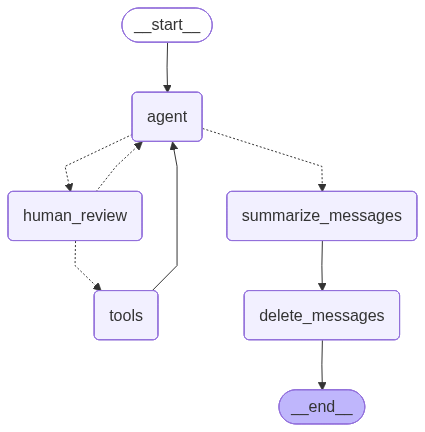

In [153]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [154]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query = 'LLM Survey 논문의 내용을 검색해서 요약해주세요'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_izJ9pUSDA2pVJ4xtNUs3oalC)
 Call ID: call_izJ9pUSDA2pVJ4xtNUs3oalC
  Args:
    query: LLM Survey


In [138]:
for chunk in graph.stream(
    Command(resume={'action': 'update_args', 'data': {'query': 'Large Language Model: A Survey'}}),
            config,
            stream_mode="updates",
):
    print(chunk)

{'human_review': {'messages': [{'id': 'run-c67f70ad-56b2-4285-ad0e-3ff8c21e2487-0', 'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_gUd07r93dhfa70gRRvcqt80C', 'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}}]}]}}
{'tools': {'messages': [ToolMessage(content="Published: 2015-08-17\nTitle: Observation of the rare $B^0_s\\toμ^+μ^-$ decay from the combined analysis of CMS and LHCb data\nAuthors: The CMS, LHCb Collaborations, :, V. Khachatryan, A. M. Sirunyan, A. Tumasyan, W. Adam, T. Bergauer, M. Dragicevic, J. Erö, M. Friedl, R. Frühwirth, V. M. Ghete, C. Hartl, N. Hörmann, J. Hrubec, M. Jeitler, W. Kiesenhofer, V. Knünz, M. Krammer, I. Krätschmer, D. Liko, I. Mikulec, D. Rabady, B. Rahbaran, H. Rohringer, R. Schöfbeck, J. Strauss, W. Treberer-Treberspurg, W. Waltenberger, C. -E. Wulz, V. Mossolov, N. Shumeiko, J. Suarez Gonzalez, S. Alderweireldt, S. Bansal, T. Cornelis, E. A. De Wolf, X. Janssen, A. Knutsson, J. Lauwers, S. Luyckx, S. Ochesanu, R. Rougny, M.

위 셀에서 다음과 같이 선언함
- review_data = human_review.get('data', None)
- 'args': review_data # 수정  
- 여기에서 data': {'query': 'Large Language Model: A Survey'}로 수정